### Importing required libraries


In [31]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

### Setting Batch Size, Image size, Channels, Epochs

In [19]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNEL = 3
EPOCHS = 15

### Extracting data using api

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 0 2 1 1 0 1 2 1 0 0 0 0 0 0 2 1 1 0 0 0 1 1 2 0 1 0 1 0 1 1 0]


### Plotting images using numpy functions

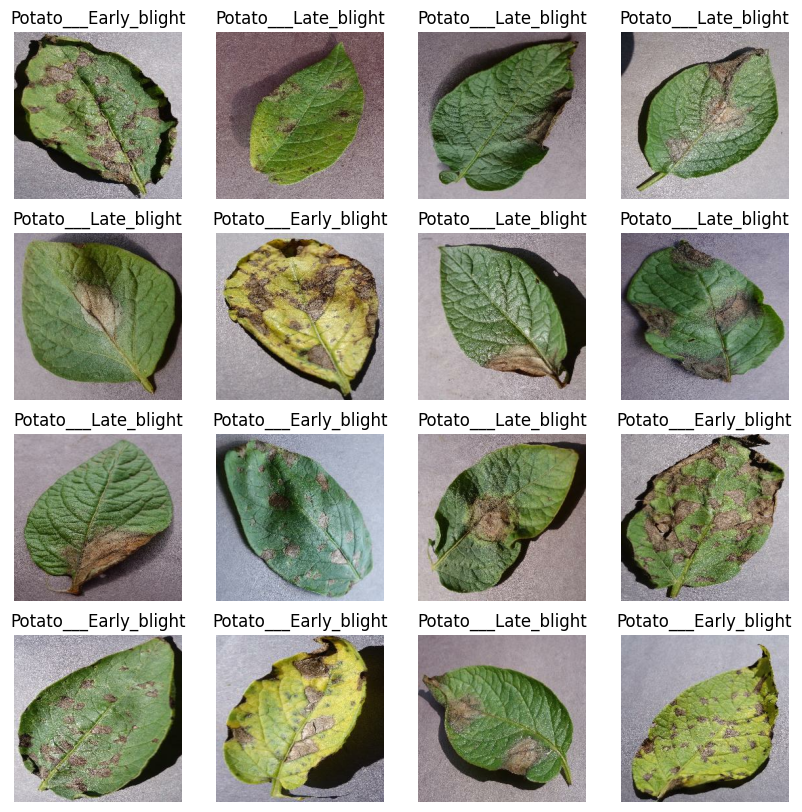

In [7]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

### Partitioning Dataset (80% Train, 10% Testing, 10% Validation)

In [8]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, test_ds, val_ds

In [9]:
train_ds, test_ds, val_ds = get_dataset_partitions_tf(dataset)

In [10]:
len(train_ds)

54

In [11]:
len(test_ds)

8

In [12]:
len(val_ds)

6

### Caching and Prefetching

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

### Creating Layers and Data Augmentation

In [14]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [15]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [16]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax')
])
model.build(input_shape = input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (32, 516128)              0         
                                                                 
 dense (Dense)               (32, 64)                  33032256  
                                                      

### Compiling Model using optimization fucntions

In [20]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [21]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds 
)

Epoch 1/15
54/54 [==============================] - 43s 745ms/step - loss: 5.2926 - accuracy: 0.6858 - val_loss: 0.7123 - val_accuracy: 0.7083
Epoch 2/15
54/54 [==============================] - 39s 731ms/step - loss: 0.4207 - accuracy: 0.8501 - val_loss: 0.6682 - val_accuracy: 0.7240
Epoch 3/15
54/54 [==============================] - 40s 733ms/step - loss: 0.3517 - accuracy: 0.8553 - val_loss: 0.2564 - val_accuracy: 0.8958
Epoch 4/15
54/54 [==============================] - 40s 738ms/step - loss: 0.2334 - accuracy: 0.9103 - val_loss: 0.1483 - val_accuracy: 0.9531
Epoch 5/15
54/54 [==============================] - 40s 738ms/step - loss: 0.1932 - accuracy: 0.9225 - val_loss: 0.2032 - val_accuracy: 0.9062
Epoch 6/15
54/54 [==============================] - 40s 739ms/step - loss: 0.2003 - accuracy: 0.9126 - val_loss: 0.1197 - val_accuracy: 0.9531
Epoch 7/15
54/54 [==============================] - 41s 751ms/step - loss: 0.1527 - accuracy: 0.9398 - val_loss: 0.1928 - val_accuracy: 0.9271

In [22]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 139ms/step - loss: 0.0618 - accuracy: 0.9766


In [23]:
scores

[0.06181748956441879, 0.9765625]

### Plotting graphs

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

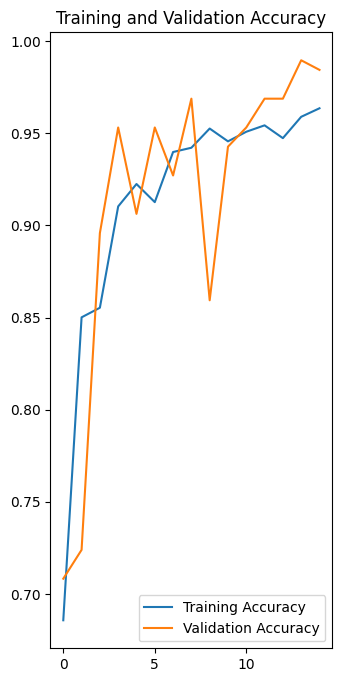

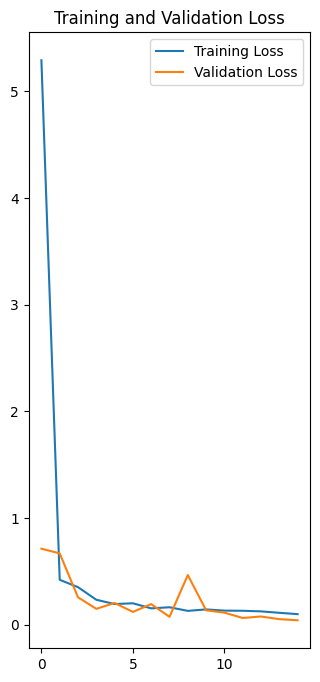

In [27]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

### Predictions and Plotting of data

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 52ms/step


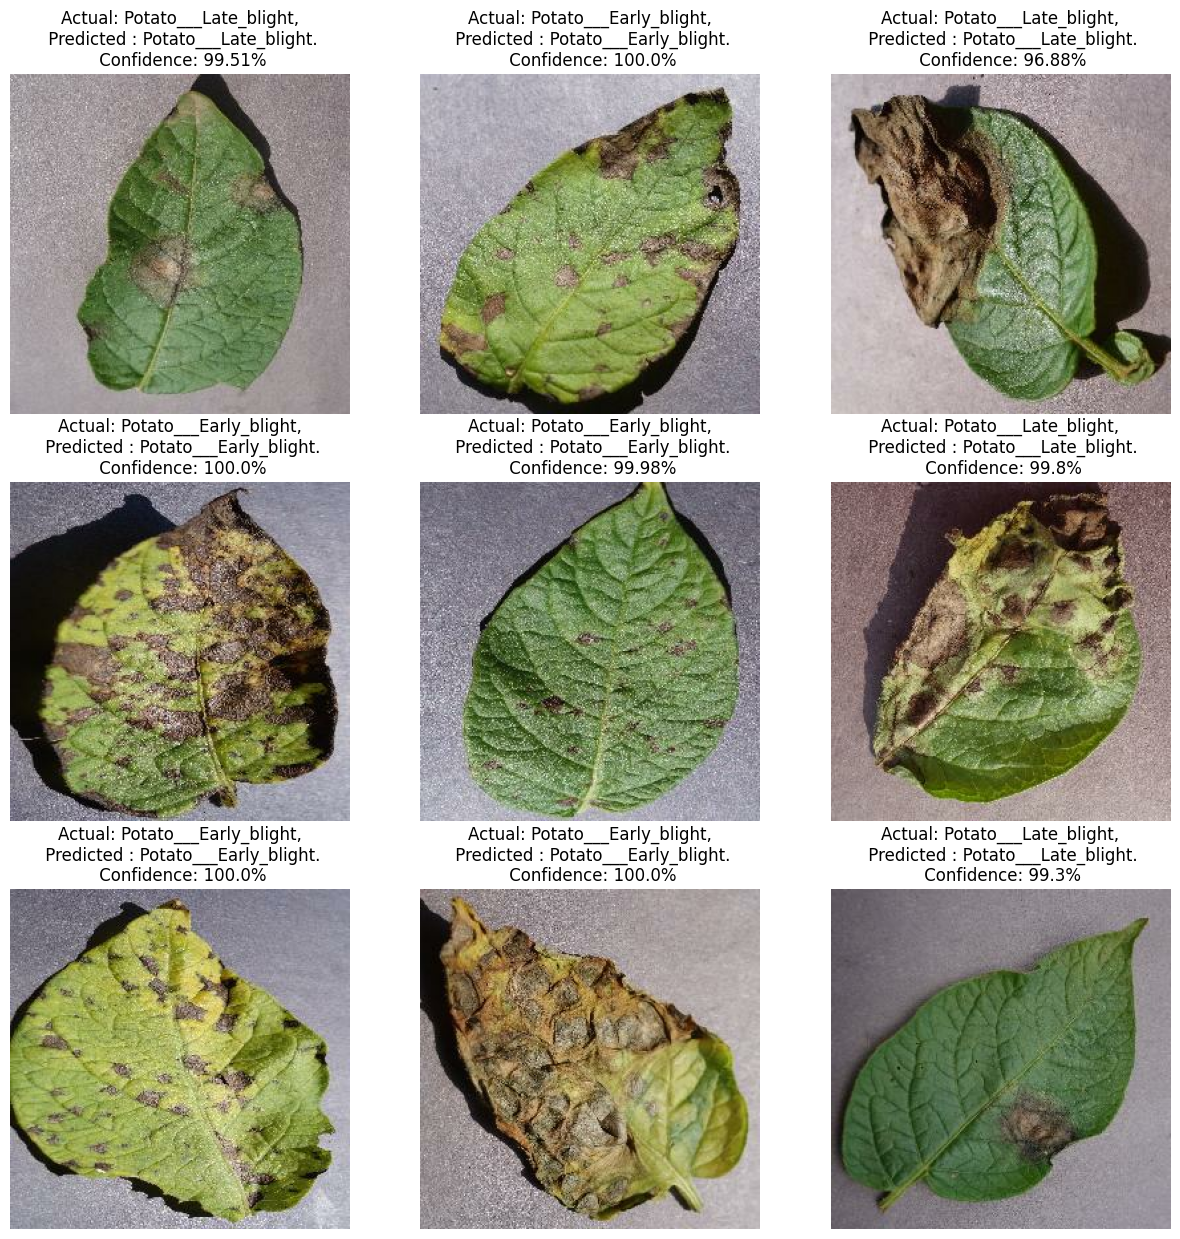

In [37]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted : {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

### Saving models

In [41]:
import os
model_version = max([int(i) for i in os.listdir("./models")+[0]])+1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1\assets


INFO:tensorflow:Assets written to: ./models/1\assets
